In [170]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import csv
import math
import json
from collections import defaultdict, OrderedDict
from pathlib import Path

def safe_float(x):
    try:
        return float(x)
    except Exception:
        return float('nan')

def combine_iq(il, ql, ir, qr):
    # 对应 calculate_vec_cmac_f 的单点版
    I = ir * il - qr * ql
    Q = ir * ql + il * qr
    return I, Q

def parse_and_combine(csv_path: str):
    """
    读取 iq_flat.csv，按 (index, ap_index) → ch 聚合，计算合成 IQ 及幅值/相位。
    返回一个 dict：key=(index, ap_index)，value=结构化结果。
    """
    results = {}
    # 暂存每个 (index, ap_index) 的公共 meta（以第一条为准）
    meta_map = {}
    # 暂存每个 (index, ap_index) 下各通道的原始 il/ql/ir/qr
    chans_map = defaultdict(dict)  # {(index, ap_index): {ch: {il,ql,ir,qr}}}

    with open(csv_path, "r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            try:
                index = int(row["index"])
                ap_index = int(row["ap_index"])
                key = (index, ap_index)

                # 记录 meta（只填一次）
                if key not in meta_map:
                    meta_map[key] = {
                        "index": index,
                        "timestamp_ms": int(float(row.get("timestamp_ms", "nan"))),
                        "role": row.get("role"),
                        "ap_index": ap_index,
                        "tone_quality": row.get("tone_quality"),
                        "distance_ifft": safe_float(row.get("distance_ifft", "nan")),
                        "distance_phase_slope": safe_float(row.get("distance_phase_slope", "nan")),
                        "distance_rtt": safe_float(row.get("distance_rtt", "nan")),
                        "distance_best": safe_float(row.get("distance_best", "nan")),
                    }

                ch = int(row["ch"])
                il = safe_float(row["il"])
                ql = safe_float(row["ql"])
                ir = safe_float(row["ir"])
                qr = safe_float(row["qr"])

                chans_map[key][ch] = {"il": il, "ql": ql, "ir": ir, "qr": qr}
            except Exception:
                # 忽略不合规行
                continue

    # 计算合成 I/Q、幅值、相位
    for key, ch_dict in chans_map.items():
        # 保持通道有序
        ordered_channels = OrderedDict(sorted(ch_dict.items(), key=lambda kv: kv[0]))
        result_entry = {
            "meta": meta_map.get(key, {}),
            "channels": OrderedDict()
        }
        for ch, vals in ordered_channels.items():
            il, ql, ir, qr = vals["il"], vals["ql"], vals["ir"], vals["qr"]
            I, Q = combine_iq(il, ql, ir, qr)
            mag = math.hypot(I, Q)  # sqrt(I^2 + Q^2)
            phase = math.atan2(Q, I)  # 弧度

            result_entry["channels"][ch] = {
                "il": il, "ql": ql, "ir": ir, "qr": qr,
                "I": I, "Q": Q,
                "mag": mag,
                "phase_rad": phase
                # 如需角度： "phase_deg": math.degrees(phase)
            }
        results[key] = result_entry

    return results

def save_combined_csv(results: dict, out_csv: str):
    """
    扁平化导出合成结果，便于直接画图或 pandas 使用。
    列：index,timestamp_ms,role,ap_index,tone_quality,dist_*,ch,il,ql,ir,qr,I,Q,mag,phase_rad
    """
    header = [
        "index","timestamp_ms","role","ap_index","tone_quality",
        "distance_ifft","distance_phase_slope","distance_rtt","distance_best",
        "ch","il","ql","ir","qr","I","Q","mag","phase_rad"
    ]
    with open(out_csv, "w", newline="", encoding="utf-8") as w:
        writer = csv.writer(w)
        writer.writerow(header)
        for (index, ap_index), entry in sorted(results.items()):
            meta = entry["meta"]
            for ch, v in entry["channels"].items():
                writer.writerow([
                    meta.get("index"), meta.get("timestamp_ms"), meta.get("role"),
                    meta.get("ap_index"), meta.get("tone_quality"),
                    meta.get("distance_ifft"), meta.get("distance_phase_slope"),
                    meta.get("distance_rtt"), meta.get("distance_best"),
                    ch, v["il"], v["ql"], v["ir"], v["qr"],
                    v["I"], v["Q"], v["mag"], v["phase_rad"]
                ])

def save_combined_json(results: dict, out_json: str):
    """
    将 results（以 (index, ap_index) 为键的 dict）转换为列表再保存 JSON。
    每个元素包含 meta 和 channels，且顶层显式带 index, ap_index 字段。
    """
    serializable = []
    for (index, ap_index), entry in sorted(results.items()):
        serializable.append({
            "index": index,
            "ap_index": ap_index,
            "meta": entry.get("meta", {}),
            "channels": entry.get("channels", {})  # channels 是 OrderedDict[int -> dict]，可直接序列化
        })
    with open(out_json, "w", encoding="utf-8") as w:
        json.dump(serializable, w, ensure_ascii=False, indent=2)

if __name__ == "__main__":
    # 使用示例
    # UartAssist.bre.n5+l1_20250817_145410_iq_flat
    in_csv = "UartAssist.bre.n1+3.sweephands5leftright_20250812_161735_iq_flat.csv"           # 你的输入 CSV 文件名
    out_csv = "combined_iq" + in_csv + ".csv"      # 合成结果 CSV
    out_json = "combined_iq"+ in_csv + ".json"    # 合成结果 JSON（结构化，便于调试/二次处理）

    results = parse_and_combine(in_csv)
    print(f"parsed (report, ap) groups: {len(results)}")

    save_combined_csv(results, out_csv)
    save_combined_json(results, out_json)
    print(f"Saved: {out_csv}")
    print(f"Saved: {out_json}")

parsed (report, ap) groups: 222
Saved: combined_iqUartAssist.bre.n1+3.sweephands5leftright_20250812_161735_iq_flat.csv.csv
Saved: combined_iqUartAssist.bre.n1+3.sweephands5leftright_20250812_161735_iq_flat.csv.json


In [171]:
import json
import math
import numpy as np
import matplotlib.pyplot as plt
read_csv = "combined_iqUartAssist.1mcable_20250816_182503_iq_flat.csv.csv"
# combined_iqUartAssist.1mcable_20250816_182503_iq_flat.csv
# combined_iqUartAssist.bre.n1+3.sweephands5leftright_20250812_161735_iq_flat.csv
# combined_iqUartAssist.bre.n5+l1_20250817_145410_iq_flat.csv.json,幅相关系用图
read_json = "combined_iqUartAssist.bre.n1+3.sweephands5leftright_20250812_161735_iq_flat.csv.json"
# 读取并预处理
with open(read_json, "r", encoding="utf-8") as f:
    data_to_parse = json.load(f)  # list of {index, ap_index, meta, channels}


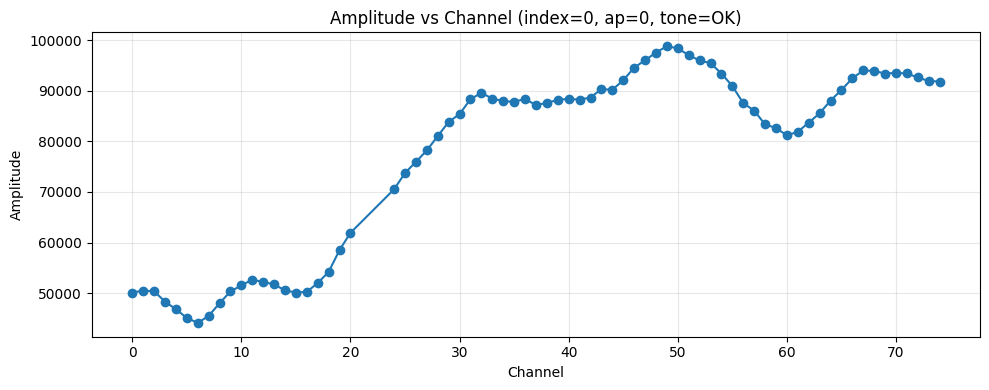

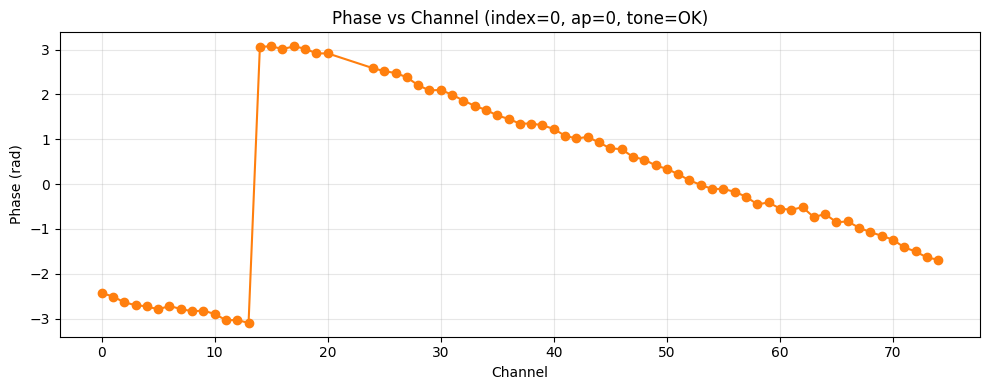

In [172]:

# 将 channels 的键由 str 转回 int，并按 ch 升序排列
for item in data_to_parse:
    item["channels"] = {int(k): v for k, v in item["channels"].items()}

# 选择要画的 report 和 AP
target_index = 0        # 想看的 report index
target_ap = 0           # 想看的 ap_index

entry = next(
    (it for it in data_to_parse if it["index"] == target_index and it["ap_index"] == target_ap),
    None
)
if entry is None:
    raise ValueError(f"找不到 index={target_index}, ap_index={target_ap} 的条目")

# 取出通道、有序排列
chs = sorted(entry["channels"].keys())
I = np.array([entry["channels"][ch]["I"] for ch in chs], dtype=float)
Q = np.array([entry["channels"][ch]["Q"] for ch in chs], dtype=float)
mag = np.array([entry["channels"][ch]["mag"] for ch in chs], dtype=float)
phase_rad = np.array([entry["channels"][ch]["phase_rad"] for ch in chs], dtype=float)
phase_deg = np.degrees(phase_rad)  # 若想用度数显示

# 去除0通道和NaN
is_nan = np.isnan(I) | np.isnan(Q) | np.isnan(mag) | np.isnan(phase_rad)

# 判全 0：mag==0 或 (I==0 且 Q==0)。加入阈值更稳健：
eps = 1e-12
is_zero = (np.abs(mag) <= eps) | ((np.abs(I) <= eps) & (np.abs(Q) <= eps))

mask = ~(is_nan | is_zero)

chs = np.array(chs)[mask].tolist()   # 保留后的通道索引
I = I[mask]
Q = Q[mask]
mag = mag[mask]
phase_rad = phase_rad[mask]
phase_deg = np.degrees(phase_rad)

# 幅值 vs 通道
plt.figure(figsize=(10, 4))
plt.plot(chs, mag, marker='o', lw=1.5)
plt.title(f"Amplitude vs Channel (index={entry['index']}, ap={entry['ap_index']}, tone={entry['meta'].get('tone_quality')})")
plt.xlabel("Channel")
plt.ylabel("Amplitude")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'./finebre.fig/Amplitude vs Channel.svg', dpi=300)
plt.savefig(f'./finebre.fig/Amplitude vs Channel.pdf', dpi=300) 
plt.show()

# 相位 vs 通道（以度为例，也可改用 phase_rad）
plt.figure(figsize=(10, 4))
plt.plot(chs, phase_rad, marker='o', lw=1.5, color='tab:orange')
plt.title(f"Phase vs Channel (index={entry['index']}, ap={entry['ap_index']}, tone={entry['meta'].get('tone_quality')})")
plt.xlabel("Channel")
plt.ylabel("Phase (rad)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'./finebre.fig/Phase vs Channel.svg', dpi=300)
plt.savefig(f'./finebre.fig/Phase vs Channel.pdf', dpi=300) 
plt.show()

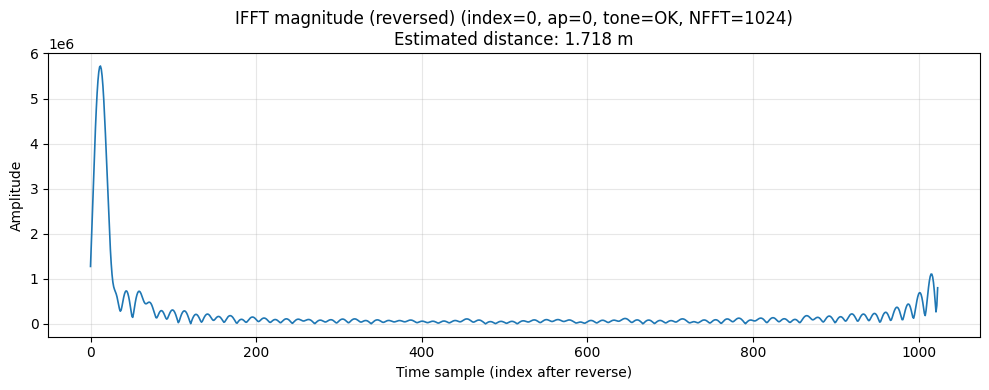

In [173]:
import json
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, atan2, pi

# 常量（与固件保持一致）
PI = 3.14159265358979
C = 299792458.0
CHANNEL_INDEX_OFFSET = 2         # 物理信道号偏移
NUM_CHANNELS = 75
CHANNEL_SPACING_HZ = 1e6
NORMAL_PEAK_TO_NULL = None       # 由 NFFT 和 NUM_CHANNELS 决定
# NFFT：请根据你的固件配置设置（512/1024/2048）。这里示例设为 1024：
NFFT = 1024

NORMAL_PEAK_TO_NULL = (NFFT + NUM_CHANNELS - 1) // NUM_CHANNELS

def interpolate_missing_frequencies(iq_2n):
    """
    iq_2n: shape (2*NUM_CHANNELS,), [I0,Q0, I1,Q1, ...]
    缺失的物理信道 23/24/25（索引 21/22/23）用 22 与 26 做线性插值。
    22 → idx = 22-2 = 20
    26 → idx = 26-2 = 24
    插值填充 idx=21,22,23
    """
    ch_22 = 22 - CHANNEL_INDEX_OFFSET  # 20
    ch_26 = 26 - CHANNEL_INDEX_OFFSET  # 24
    i_slope = (iq_2n[2*ch_26]     - iq_2n[2*ch_22])     / 4.0
    q_slope = (iq_2n[2*ch_26 + 1] - iq_2n[2*ch_22 + 1]) / 4.0
    for i in range(ch_22 + 1, ch_26):
        iq_2n[2*i]     = iq_2n[2*ch_22]     + i_slope * (i - ch_22)
        iq_2n[2*i + 1] = iq_2n[2*ch_22 + 1] + q_slope * (i - ch_22)

def calculate_ifft_find_left_null(peak_index, ifft_mag):
    left_null_index = peak_index
    N = len(ifft_mag)
    found = False
    while not found:
        next_left = (N - 1) if left_null_index == 0 else (left_null_index - 1)
        # 与固件同一启发式
        if ((ifft_mag[left_null_index] * 2 > ifft_mag[peak_index] or
             ifft_mag[left_null_index] > 1.10 * ifft_mag[next_left]) and
            ifft_mag[left_null_index] * 10 > ifft_mag[peak_index] and
            next_left != peak_index):
            left_null_index = next_left
        else:
            found = True
    return left_null_index

def distance_to_left_null(peak_index, left_null_index, N):
    return (N + peak_index - left_null_index) if left_null_index > peak_index else (peak_index - left_null_index)

def left_null_compensation_of_peak(peak_index, ifft_mag):
    N = len(ifft_mag)
    left_null_index = calculate_ifft_find_left_null(peak_index, ifft_mag)
    peak_to_null = distance_to_left_null(peak_index, left_null_index, N)
    compensated = peak_index
    if peak_to_null > NORMAL_PEAK_TO_NULL:
        if left_null_index > peak_index:
            compensated = max(0, left_null_index + NORMAL_PEAK_TO_NULL - N)
        else:
            compensated = left_null_index + NORMAL_PEAK_TO_NULL
    return compensated

def calculate_ifft_peak_index_to_distance(peak_index, ifft_mag):
    N = len(ifft_mag)
    prompt = ifft_mag[peak_index]
    early = ifft_mag[peak_index - 1] if peak_index != 0 else ifft_mag[N - 1]
    late  = ifft_mag[peak_index + 1] if peak_index != (N - 1) else ifft_mag[0]
    if (prompt >= early) and (prompt >= late):
        denom = 4*prompt - 2*(early + late)
        t_hat = (late - early) / denom if denom != 0 else 0.0
    else:
        t_hat = 0.0
    distance = ((peak_index + t_hat) * C) / (2.0 * NFFT * CHANNEL_SPACING_HZ)
    if (peak_index >= (NFFT - 2)) or (distance < 0.0):
        distance = float('nan')
    return distance

def calculate_dist_ifft_py(IQ_comb):
    """
    IQ_comb: shape (NUM_CHANNELS, 2) 或 (2*NUM_CHANNELS,), 已为 I+ jQ 的“合成后”频域样本
    返回 (dist_ifft_m, ifft_mag_reversed)
    """
    # 组装为长度 2*NUM_CHANNELS 的数组 [I0,Q0, I1,Q1, ...]
    if IQ_comb.ndim == 2:
        iq_2n = IQ_comb.astype(np.float32).ravel()
    else:
        iq_2n = IQ_comb.astype(np.float32).copy()
    # 缺失频点插值
    interpolate_missing_frequencies(iq_2n)

    # 检查是否存在全 0 频点（与固件同逻辑：若有 0+0j 的频点则直接判无法计算）
    for n in range(0, 2*NUM_CHANNELS, 2):
        if iq_2n[n] == 0.0 and iq_2n[n+1] == 0.0:
            # 与固件一致：直接返回 NaN，不再做 FFT
            return float('nan'), None

    # 把 75 个复数频点嵌入到 NFFT 点（其余为 0）
    X = np.zeros(NFFT, dtype=np.complex64)
    # 这里默认把 75 点放在频谱的低端连续 bins（与固件内部布局一致）
    for k in range(NUM_CHANNELS):
        I = iq_2n[2*k]; Q = iq_2n[2*k+1]
        X[k] = I + 1j*Q

    # 固件调用的是 arm_cfft_f32(..., ifftFlag=0, doBitReverse=1)，属于“正向变换核”+内部位逆序。
    # 在 numpy 中，用 FFT 或 IFFT 的区别在于符号与缩放；固件后续进行了幅值化与反转。
    # 经验上使用 np.fft.fft 与后续幅值化、反转可以得到一致的峰搜索位置。
    Y = np.fft.fft(X, n=NFFT)

    # 计算幅值谱（与固件相同：sqrt(re^2 + im^2)）
    ifft_mag = np.abs(Y).astype(np.float32)

    # 反转数组（固件把 [0..N-1] 倒序）
    ifft_mag_rev = ifft_mag[::-1].copy()

    # 全局最大
    ifft_mag_max_index = int(np.argmax(ifft_mag_rev))
    ifft_mag_max = float(ifft_mag_rev[ifft_mag_max_index])

    # “最短路径搜索”：从数组尾部向前寻找接近全局最大、且更靠近零延迟一侧的强峰
    N = NFFT
    nw = N - 2
    nw_next = N - 1
    max_search_index = ifft_mag_max_index
    short_path_found = False
    first_rise_found = False
    shortest_path_idx = ifft_mag_max_index

    while (nw != max_search_index) and (not short_path_found):
        if ifft_mag_rev[nw_next] < ifft_mag_rev[nw]:
            # 峰
            if 2.5 * ifft_mag_rev[nw] > ifft_mag_max and first_rise_found:
                shortest_path_idx = nw
                short_path_found = True
        else:
            first_rise_found = True
        nw = nw_next
        nw_next = (nw_next + 1) % N

    compensated_peak_index = shortest_path_idx
    if compensated_peak_index < (N - 2):
        compensated_peak_index = left_null_compensation_of_peak(compensated_peak_index, ifft_mag_rev)

    dist = calculate_ifft_peak_index_to_distance(compensated_peak_index, ifft_mag_rev)
    return dist, ifft_mag_rev

def plot_ifft_result(ifft_mag_rev, dist, title_suffix=""):
    N = len(ifft_mag_rev)
    n = np.arange(N)
    # 可额外给出等效延迟轴（秒）与距离轴（米）
    # tau = n / (NFFT * CHANNEL_SPACING_HZ)
    # d = (C * tau) / 2
    plt.figure(figsize=(10,4))
    plt.plot(n, ifft_mag_rev, lw=1.2)
    plt.title(f"IFFT magnitude (reversed) {title_suffix}\nEstimated distance: {dist:.3f} m" if np.isfinite(dist) else f"IFFT magnitude (reversed) {title_suffix}\nEstimated distance: NaN")
    plt.xlabel("Time sample (index after reverse)")
    plt.ylabel("Amplitude")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ===== 示例：从 combined_iq.json 取某个 (index, ap) 的 IQ，计算并作图 =====

# 读取数据
# with open("combined_iq.json", "r", encoding="utf-8") as f:
#     data = json.load(f)

# 选择 index 和 ap
target_index = 0
target_ap = 0
entry = next((it for it in data_to_parse if it["index"] == target_index and it["ap_index"] == target_ap), None)
if entry is None:
    raise ValueError("未找到目标 (index, ap)")

# 构造 NUM_CHANNELS 长度的 I/Q 序列（注意 channels key 转 int）
channels = {int(k): v for k, v in entry["channels"].items()}
chs = sorted(channels.keys())

# 验证通道数量（期望 0..74 共 75 个；如有缺失，先按 0 填充，后续会触发无法计算 IFFT 的早退）
IQ = np.zeros((NUM_CHANNELS, 2), dtype=np.float32)
for ch in range(NUM_CHANNELS):
    if ch in channels:
        I = float(channels[ch]["I"])
        Q = float(channels[ch]["Q"])
        IQ[ch, 0] = I
        IQ[ch, 1] = Q
    else:
        IQ[ch, :] = 0.0

# 计算距离与谱
dist_ifft, ifft_mag_rev = calculate_dist_ifft_py(IQ)

# 作图
if ifft_mag_rev is not None:
    title = f"(index={entry['index']}, ap={entry['ap_index']}, tone={entry['meta'].get('tone_quality')}, NFFT={NFFT})"
    plot_ifft_result(ifft_mag_rev, dist_ifft, title_suffix=title)
else:
    print("无法计算 IFFT（存在缺失频点为 0+0j），距离为 NaN。")

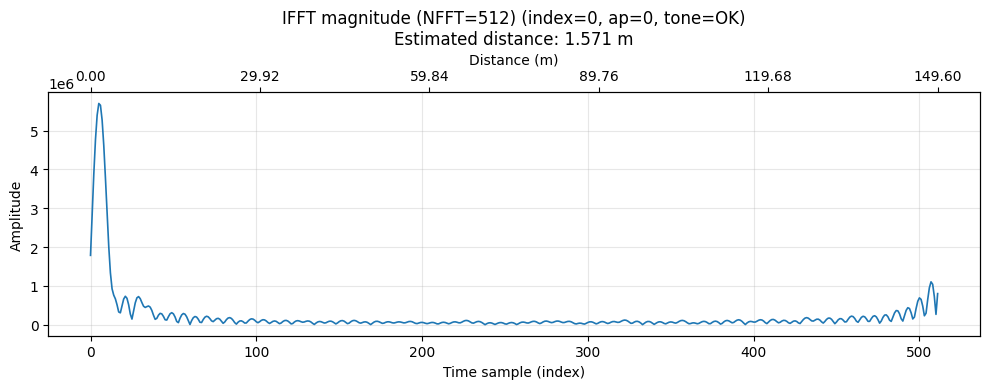

In [174]:
import json
import numpy as np
import matplotlib.pyplot as plt

# 常量（与固件保持一致）
PI = 3.14159265358979
C = 299792458.0
CHANNEL_INDEX_OFFSET = 2
NUM_CHANNELS = 75
CHANNEL_SPACING_HZ = 1e6
NFFT = 512
NORMAL_PEAK_TO_NULL = (NFFT + NUM_CHANNELS - 1) // NUM_CHANNELS  # 与固件一致

def interpolate_missing_frequencies(iq_2n):
    """
    iq_2n: shape (2*NUM_CHANNELS,), [I0,Q0, I1,Q1, ...]
    缺失物理信道 23/24/25（索引 21/22/23）用 22 与 26 线性插值。
    """
    ch_22 = 22 - CHANNEL_INDEX_OFFSET  # 20
    ch_26 = 26 - CHANNEL_INDEX_OFFSET  # 24
    i_slope = (iq_2n[2*ch_26]     - iq_2n[2*ch_22])     / 4.0
    q_slope = (iq_2n[2*ch_26 + 1] - iq_2n[2*ch_22 + 1]) / 4.0
    for i in range(ch_22 + 1, ch_26):
        iq_2n[2*i]     = iq_2n[2*ch_22]     + i_slope * (i - ch_22)
        iq_2n[2*i + 1] = iq_2n[2*ch_22 + 1] + q_slope * (i - ch_22)

def calculate_ifft_find_left_null(peak_index, ifft_mag):
    left_null_index = peak_index
    N = len(ifft_mag)
    found = False
    while not found:
        next_left = (N - 1) if left_null_index == 0 else (left_null_index - 1)
        if ((ifft_mag[left_null_index] * 2 > ifft_mag[peak_index] or
             ifft_mag[left_null_index] > 1.10 * ifft_mag[next_left]) and
            ifft_mag[left_null_index] * 10 > ifft_mag[peak_index] and
            next_left != peak_index):
            left_null_index = next_left
        else:
            found = True
    return left_null_index

def distance_to_left_null(peak_index, left_null_index, N):
    return (N + peak_index - left_null_index) if left_null_index > peak_index else (peak_index - left_null_index)

def left_null_compensation_of_peak(peak_index, ifft_mag):
    N = len(ifft_mag)
    left_null_index = calculate_ifft_find_left_null(peak_index, ifft_mag)
    peak_to_null = distance_to_left_null(peak_index, left_null_index, N)
    compensated = peak_index
    if peak_to_null > NORMAL_PEAK_TO_NULL:
        if left_null_index > peak_index:
            compensated = max(0, left_null_index + NORMAL_PEAK_TO_NULL - N)
        else:
            compensated = left_null_index + NORMAL_PEAK_TO_NULL
    return compensated

def calculate_ifft_peak_index_to_distance(peak_index, ifft_mag):
    N = len(ifft_mag)
    prompt = ifft_mag[peak_index]
    early = ifft_mag[peak_index - 1] if peak_index != 0 else ifft_mag[N - 1]
    late  = ifft_mag[peak_index + 1] if peak_index != (N - 1) else ifft_mag[0]
    if (prompt >= early) and (prompt >= late):
        denom = 4*prompt - 2*(early + late)
        t_hat = (late - early) / denom if denom != 0 else 0.0
    else:
        t_hat = 0.0
    distance = ((peak_index + t_hat) * C) / (2.0 * NFFT * CHANNEL_SPACING_HZ)
    if (peak_index >= (NFFT - 2)) or (distance < 0.0):
        distance = float('nan')
    return distance

def calculate_dist_ifft_py(IQ_comb):
    """
    IQ_comb: shape (NUM_CHANNELS, 2) 或 (2*NUM_CHANNELS,), 为“合成后”的 I/Q 频域样本。
    返回 (dist_ifft_m, ifft_mag_reversed)
    """
    if IQ_comb.ndim == 2:
        iq_2n = IQ_comb.astype(np.float32).ravel()
    else:
        iq_2n = IQ_comb.astype(np.float32).copy()

    # 缺失频点插值
    interpolate_missing_frequencies(iq_2n)

    # 若存在任何 0+0j，固件直接放弃 IFFT
    for n in range(0, 2*NUM_CHANNELS, 2):
        if iq_2n[n] == 0.0 and iq_2n[n+1] == 0.0:
            return float('nan'), None

    # 嵌入 NFFT 点频谱
    X = np.zeros(NFFT, dtype=np.complex64)
    for k in range(NUM_CHANNELS):
        I = iq_2n[2*k]; Q = iq_2n[2*k+1]
        X[k] = I + 1j*Q

    # 变换（参照固件用 cfft + 后处理，这里使用 numpy FFT）
    Y = np.fft.fft(X, n=NFFT)
    ifft_mag = np.abs(Y).astype(np.float32)

    # 反转（与固件一致）
    ifft_mag_rev = ifft_mag[::-1].copy()

    # 全局最大
    ifft_mag_max_index = int(np.argmax(ifft_mag_rev))
    ifft_mag_max = float(ifft_mag_rev[ifft_mag_max_index])

    # “最短路径”搜索
    N = NFFT
    nw = N - 2
    nw_next = N - 1
    max_search_index = ifft_mag_max_index
    short_path_found = False
    first_rise_found = False
    shortest_path_idx = ifft_mag_max_index

    while (nw != max_search_index) and (not short_path_found):
        if ifft_mag_rev[nw_next] < ifft_mag_rev[nw]:
            if 2.5 * ifft_mag_rev[nw] > ifft_mag_max and first_rise_found:
                shortest_path_idx = nw
                short_path_found = True
        else:
            first_rise_found = True
        nw = nw_next
        nw_next = (nw_next + 1) % N

    compensated_peak_index = shortest_path_idx
    if compensated_peak_index < (N - 2):
        compensated_peak_index = left_null_compensation_of_peak(compensated_peak_index, ifft_mag_rev)

    dist = calculate_ifft_peak_index_to_distance(compensated_peak_index, ifft_mag_rev)
    return dist, ifft_mag_rev

def plot_ifft_result(ifft_mag_rev, dist, title_suffix=""):
    N = len(ifft_mag_rev)
    n = np.arange(N)
    # 也给出距离轴
    tau = n / (NFFT * CHANNEL_SPACING_HZ)             # 秒
    d_axis = (C * tau) / 2.0                          # 米

    fig, ax1 = plt.subplots(figsize=(10,4))
    ax1.plot(n, ifft_mag_rev, lw=1.2, label="IFFT magnitude (reversed)")
    ax1.set_xlabel("Time sample (index)")
    ax1.set_ylabel("Amplitude")
    ax1.grid(True, alpha=0.3)
    title = f"IFFT magnitude (NFFT={NFFT}) {title_suffix}"
    if np.isfinite(dist):
        title += f"\nEstimated distance: {dist:.3f} m"
    ax1.set_title(title)

    # 距离副坐标轴
    ax2 = ax1.twiny()
    ax2.set_xlim(ax1.get_xlim())
    # 将索引轴映射到距离轴的刻度（选取少量刻度防止重叠）
    tick_pos = np.linspace(0, N-1, num=6)
    tick_dist = ((tick_pos) * C) / (2.0 * NFFT * CHANNEL_SPACING_HZ)
    ax2.set_xticks(tick_pos)
    ax2.set_xticklabels([f"{td:.2f}" for td in tick_dist])
    ax2.set_xlabel("Distance (m)")

    plt.tight_layout()
    plt.show()

# ===== 示例：从 combined_iq.json 中选择一个 (index, ap) =====
# with open("combined_iq.json", "r", encoding="utf-8") as f:
#     data = json.load(f)

target_index = 0
target_ap = 0
entry = next((it for it in data_to_parse if it["index"] == target_index and it["ap_index"] == target_ap), None)
if entry is None:
    raise ValueError("未找到目标 (index, ap)")

channels = {int(k): v for k, v in entry["channels"].items()}
IQ = np.zeros((NUM_CHANNELS, 2), dtype=np.float32)
for ch in range(NUM_CHANNELS):
    if ch in channels:
        IQ[ch, 0] = float(channels[ch]["I"])
        IQ[ch, 1] = float(channels[ch]["Q"])
    else:
        IQ[ch, :] = 0.0

dist_ifft, ifft_mag_rev = calculate_dist_ifft_py(IQ)

if ifft_mag_rev is not None:
    title = f"(index={entry['index']}, ap={entry['ap_index']}, tone={entry['meta'].get('tone_quality')})"
    plot_ifft_result(ifft_mag_rev, dist_ifft, title_suffix=title)
else:
    print("无法计算 IFFT（存在缺失频点为 0+0j），距离估计为 NaN。")

画呼吸波形图

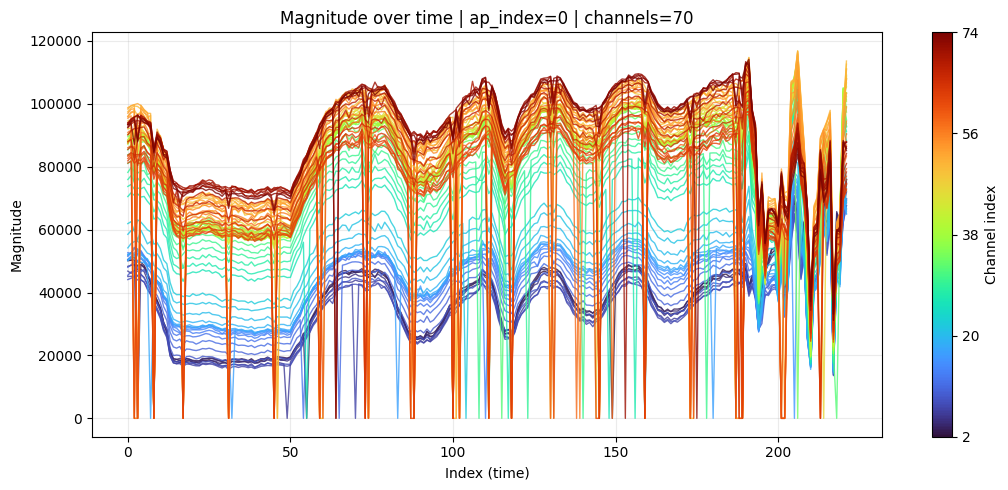

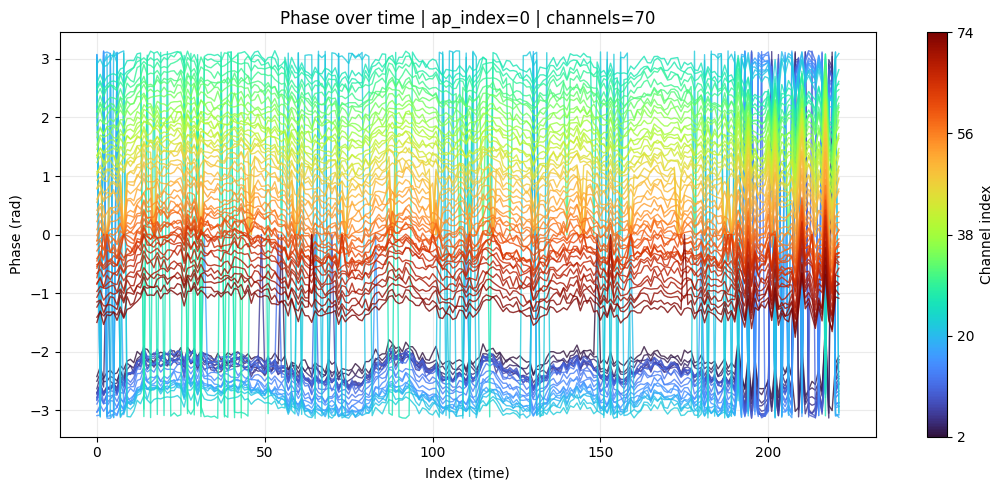

In [175]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import pi
from typing import List, Dict, Any, Optional, Iterable, Tuple

def compute_mag_phase(I, Q):
    I = np.asarray(I, dtype=float)
    Q = np.asarray(Q, dtype=float)
    mag = np.hypot(I, Q)
    phase = np.arctan2(Q, I)
    return mag, phase

DISABLED_REAL_CHS = {0, 1, 23, 24, 25, 77, 78, 79}

def prepare_series_from_entries(
    entries: List[Dict[str, Any]],
    ap_index: int,
    channels_to_use: Optional[Iterable[int]] = None,
    ensure_sorted_by_index: bool = True,
    channel_offset: int = 2,                 # 真实信道 = 源序号 + 2
    drop_disabled: bool = True,              # 是否丢弃禁用信道
) -> Tuple[np.ndarray, List[int], np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    将 entries 转为矩阵，并把源通道号（0..79）映射为真实信道号（+channel_offset）。
    - entries: list[dict]，每条含 e["channels"][src_ch] -> {I,Q,mag,phase_rad}
    - 返回的 chs 为“真实信道号”的有序列表（去除了禁用信道）。
    - channels_to_use 如果给的是“真实信道号”，也会正确筛选。
    """
    # 过滤 ap_index
    rows = [e for e in entries if int(e.get("ap_index", -1)) == ap_index]
    if ensure_sorted_by_index:
        rows.sort(key=lambda e: int(e["index"]))
    x = np.array([int(e["index"]) for e in rows], dtype=int)

    # 1) 收集所有“源序号”->“真实信道号”的映射
    # 源序号可能以字符串存储，统一转 int
    src_to_real = {}
    all_real = set()
    for e in rows:
        for ch_str in e["channels"].keys():
            src = int(ch_str)
            real = src + channel_offset
            src_to_real[src] = real
            all_real.add(real)

    # 2) 选择实际使用的真实信道号集合
    if channels_to_use is None:
        real_chs = sorted(all_real)
    else:
        # 外部传入的 channels_to_use 视为“真实信道号”
        real_chs = sorted(int(c) for c in channels_to_use)

    # 3) 丢弃禁用信道
    if drop_disabled:
        real_chs = [c for c in real_chs if c not in DISABLED_REAL_CHS]

    # 4) 反向映射：真实->源序号（一个真实号只会对应一个源序号）
    real_to_src = {real: src for src, real in src_to_real.items() if real in real_chs}

    # 5) 初始化矩阵
    C = len(real_chs)
    N = len(rows)
    I = np.full((N, C), np.nan, dtype=float)
    Q = np.full((N, C), np.nan, dtype=float)
    MAG = np.full((N, C), np.nan, dtype=float)
    PH = np.full((N, C), np.nan, dtype=float)

    real_index_map = {real: i for i, real in enumerate(real_chs)}

    # 6) 填充矩阵（用源序号访问数据，填到真实号对应的列）
    for n, e in enumerate(rows):
        chan_dict = e["channels"]
        for ch_str, v in chan_dict.items():
            src = int(ch_str)
            real = src + channel_offset
            if real not in real_index_map:
                continue
            ci = real_index_map[real]
            Ii = float(v.get("I", np.nan))
            Qi = float(v.get("Q", np.nan))
            I[n, ci] = Ii
            Q[n, ci] = Qi
            MAG[n, ci] = float(v.get("mag", np.hypot(Ii, Qi)))
            PH[n, ci] = float(v.get("phase_rad", np.arctan2(Qi, Ii)))

    # 返回的 chs 是“真实信道号”
    return x, real_chs, I, Q, MAG, PH

def plot_channels_over_time(
    entries: List[Dict[str, Any]],
    ap_index: int = 0,
    mode: str = "magnitude",        # "magnitude" 或 "phase"
    channels_to_use: Optional[Iterable[int]] = None,
    max_channels: Optional[int] = None,
    unwrap_phase: bool = True,
    normalize_magnitude: bool = False,
    cmap_name: str = "turbo",        # 颜色映射，随信道编号渐变
    alpha: float = 0.8,
    lw: float = 1.0,
    title: Optional[str] = None,
    show_colorbar: bool = True,
):
    """
    画 0..N-1 的时间序列（index 视作时间），纵轴为幅值或相位。
    - mode: "magnitude" 或 "phase"
    - channels_to_use: 指定要画哪些信道，如 range(75) 或 [0,1,2,...]
    - max_channels: 限制最多画多少条（从小到大优先）
    - unwrap_phase: 是否对相位沿时间维 unwrap
    - normalize_magnitude: 是否对每个信道幅值做归一化（便于对比形状）
    """
    x, chs, I, Q, MAG, PH = prepare_series_from_entries(entries, ap_index, channels_to_use)

    # 限制信道数量
    if max_channels is not None and len(chs) > max_channels:
        chs = chs[:max_channels]
        idx = [i for i, ch in enumerate(prepare_series_from_entries(entries, ap_index, chs)[1])]
        # 重新生成以保证维度一致
        x, chs, I, Q, MAG, PH = prepare_series_from_entries(entries, ap_index, chs)

    N, C = MAG.shape
    if C == 0 or N == 0:
        raise ValueError("没有可绘制的数据：检查 ap_index / channels_to_use 是否正确。")

    # 相位 unwrap（对每列独立进行）
    if mode == "phase":
        Y = PH.copy()
        if unwrap_phase:
            for c in range(C):
                col = Y[:, c]
                if np.all(np.isnan(col)):
                    continue
                Y[:, c] = np.unwrap(col)
        else:
            # 可选把相位限制在 [-pi, pi]
            Y = ((Y + np.pi) % (2*np.pi)) - np.pi
        y_label = "Phase (rad, unwrapped)" if unwrap_phase else "Phase (rad)"
    else:
        # 幅值
        Y = MAG.copy()
        if normalize_magnitude:
            # 对每个信道单独归一化
            for c in range(C):
                col = Y[:, c]
                m = np.nanmax(np.abs(col))
                if np.isfinite(m) and m > 0:
                    Y[:, c] = col / m
        y_label = "Magnitude (a.u.)" if normalize_magnitude else "Magnitude"

    # 构造颜色：按信道号连续映射
    # ch_min, ch_max = min(chs), max(chs)
    # if ch_max == ch_min:
    #     normed = np.zeros(C)
    # else:
    #     normed = (np.array(chs) - ch_min) / (ch_max - ch_min)
    # cmap = plt.get_cmap(cmap_name)
    # colors = [cmap(v) for v in normed]

    # 颜色映射（保持不变）
    cmap = plt.get_cmap(cmap_name)
    ch_min, ch_max = min(chs), max(chs)
    norm = mpl.colors.Normalize(vmin=ch_min, vmax=ch_max)
    normed = norm(np.array(chs))
    colors = [cmap(v) for v in normed]


    # 绘图
    fig, ax = plt.subplots(figsize=(11, 5))
    for ci, ch in enumerate(chs):
        ax.plot(x, Y[:, ci], color=colors[ci], alpha=alpha, lw=lw, label=f"ch {ch}")

    ax.set_xlabel("Index (time)")
    ax.set_ylabel(y_label)
    if title is None:
        title = f"{mode.capitalize()} over time | ap_index={ap_index} | channels={len(chs)}"
    ax.set_title(title)
    ax.grid(True, alpha=0.25)

    # 图例：如果太多会遮挡，可仅显示首尾或关闭
    if len(chs) <= 15:
        ax.legend(ncol=3, fontsize=9)
    else:
        # 使用颜色条代替图例，表达“颜色随信道号”
        if show_colorbar:
            # sm = plt.cm.ScalarMappable(cmap=cmap)
            # sm.set_array([ch_min, ch_max])
            # cbar = plt.colorbar(sm, ax=ax)
            # cbar.set_label("Channel index")
            # # 用线性刻度标注端点
            # cbar.set_ticks([0.0, 1.0])
            # cbar.set_ticklabels([str(ch_min), str(ch_max)])
            sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
            sm.set_array([])  # 哑数据，避免警告
            cbar = plt.colorbar(sm, ax=ax)
            cbar.set_label("Channel index")
                # 可选：自定义几个整型刻度
            ticks = np.linspace(ch_min, ch_max, num=5, dtype=int)
            cbar.set_ticks(ticks)
            cbar.set_ticklabels([str(t) for t in ticks])

    plt.tight_layout()
    plt.show()

ap_index = 0
entries = [e for e in data_to_parse if int(e.get("ap_index", -1)) == ap_index]
# 建议按 index 排序，保证时间先后
entries.sort(key=lambda e: int(e["index"]))
plot_channels_over_time(entries, ap_index=0, mode="magnitude", channels_to_use=range(75), normalize_magnitude=False)
plot_channels_over_time(entries, ap_index=0, mode="phase", channels_to_use=range(75), unwrap_phase=False)


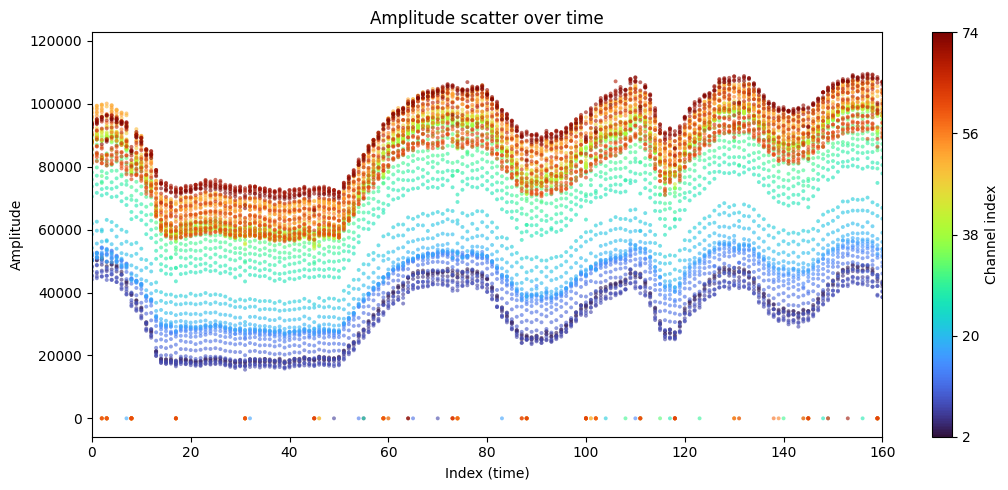

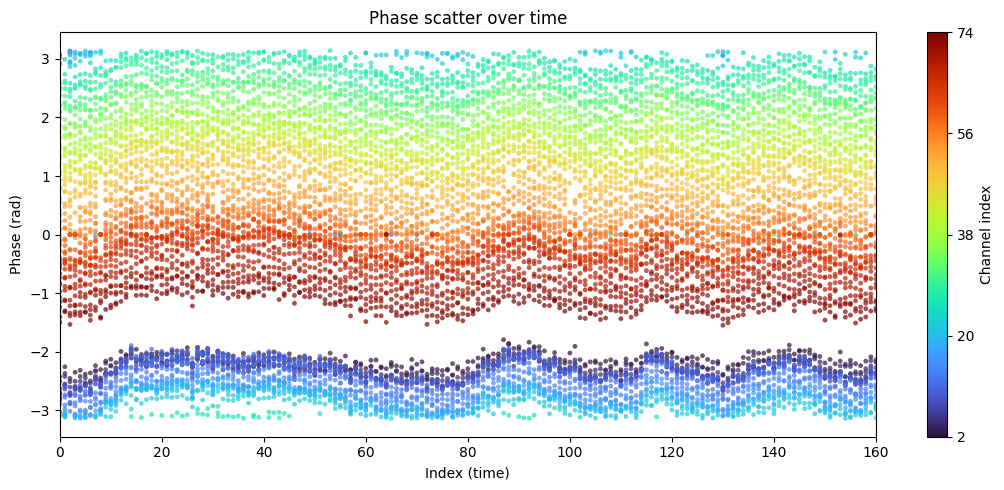

In [180]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from typing import List, Dict, Any, Optional, Iterable, Tuple

DISABLED_REAL_CHS = {0, 1, 23, 24, 25, 77, 78, 79}

def prepare_series_from_entries(
    entries: List[Dict[str, Any]],
    ap_index: int,
    channels_to_use: Optional[Iterable[int]] = None,
    ensure_sorted_by_index: bool = True,
    channel_offset: int = 2,                 # 真实信道 = 源序号 + 2
    drop_disabled: bool = True,              # 是否丢弃禁用信道
) -> Tuple[np.ndarray, List[int], np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    将 entries 转为矩阵，并把源通道号（0..79）映射为真实信道号（+channel_offset）。
    - entries: list[dict]，每条含 e["channels"][src_ch] -> {I,Q,mag,phase_rad}
    - 返回的 chs 为“真实信道号”的有序列表（去除了禁用信道）。
    - channels_to_use 如果给的是“真实信道号”，也会正确筛选。
    """
    # 过滤 ap_index
    rows = [e for e in entries if int(e.get("ap_index", -1)) == ap_index]
    if ensure_sorted_by_index:
        rows.sort(key=lambda e: int(e["index"]))
    x = np.array([int(e["index"]) for e in rows], dtype=int)

    # 1) 收集所有“源序号”->“真实信道号”的映射
    # 源序号可能以字符串存储，统一转 int
    src_to_real = {}
    all_real = set()
    for e in rows:
        for ch_str in e["channels"].keys():
            src = int(ch_str)
            real = src + channel_offset
            src_to_real[src] = real
            all_real.add(real)

    # 2) 选择实际使用的真实信道号集合
    if channels_to_use is None:
        real_chs = sorted(all_real)
    else:
        # 外部传入的 channels_to_use 视为“真实信道号”
        real_chs = sorted(int(c) for c in channels_to_use)

    # 3) 丢弃禁用信道
    if drop_disabled:
        real_chs = [c for c in real_chs if c not in DISABLED_REAL_CHS]

    # 4) 反向映射：真实->源序号（一个真实号只会对应一个源序号）
    real_to_src = {real: src for src, real in src_to_real.items() if real in real_chs}

    # 5) 初始化矩阵
    C = len(real_chs)
    N = len(rows)
    I = np.full((N, C), np.nan, dtype=float)
    Q = np.full((N, C), np.nan, dtype=float)
    MAG = np.full((N, C), np.nan, dtype=float)
    PH = np.full((N, C), np.nan, dtype=float)

    real_index_map = {real: i for i, real in enumerate(real_chs)}

    # 6) 填充矩阵（用源序号访问数据，填到真实号对应的列）
    for n, e in enumerate(rows):
        chan_dict = e["channels"]
        for ch_str, v in chan_dict.items():
            src = int(ch_str)
            real = src + channel_offset
            if real not in real_index_map:
                continue
            ci = real_index_map[real]
            Ii = float(v.get("I", np.nan))
            Qi = float(v.get("Q", np.nan))
            I[n, ci] = Ii
            Q[n, ci] = Qi
            MAG[n, ci] = float(v.get("mag", np.hypot(Ii, Qi)))
            PH[n, ci] = float(v.get("phase_rad", np.arctan2(Qi, Ii)))

    # 返回的 chs 是“真实信道号”
    return x, real_chs, I, Q, MAG, PH

def plot_channels_scatter_over_time(
    entries: List[Dict[str, Any]],
    ap_index: int = 0,
    mode: str = "amplitude",           # "magnitude" 或 "phase"
    channels_to_use: Optional[Iterable[int]] = None,
    max_channels: Optional[int] = None,
    unwrap_phase: bool = True,
    normalize_magnitude: bool = False,
    cmap_name: str = "turbo",          # 颜色按信道号渐变
    alpha: float = 0.7,
    s: float = 10.0,                   # 点大小
    edgecolors: str = "none",          # "none" 或 "face"
    title: Optional[str] = None,
    show_colorbar: bool = True,
):
    x, chs, I, Q, MAG, PH = prepare_series_from_entries(entries, ap_index, channels_to_use)

    if max_channels is not None and len(chs) > max_channels:
        chs = chs[:max_channels]
        x, chs, I, Q, MAG, PH = prepare_series_from_entries(entries, ap_index, chs)

    N, C = MAG.shape
    if C == 0 or N == 0:
        raise ValueError("没有可绘制的数据：检查 ap_index / channels_to_use 是否正确。")

    if mode == "phase":
        Y = PH.copy()
        if unwrap_phase:
            for c in range(C):
                col = Y[:, c]
                if np.all(np.isnan(col)):
                    continue
                Y[:, c] = np.unwrap(col)
        else:
            Y = ((Y + np.pi) % (2*np.pi)) - np.pi
        y_label = "Phase (rad, unwrapped)" if unwrap_phase else "Phase (rad)"
    else:
        Y = MAG.copy()
        if normalize_magnitude:
            for c in range(C):
                col = Y[:, c]
                m = np.nanmax(np.abs(col))
                if np.isfinite(m) and m > 0:
                    Y[:, c] = col / m
        y_label = "Amplitude (a.u.)" if normalize_magnitude else "Amplitude"

    # ch_min, ch_max = min(chs), max(chs)
    # normed = np.zeros(C) if ch_max == ch_min else (np.array(chs) - ch_min) / (ch_max - ch_min)
    
        # 颜色映射（保持不变）
    cmap = plt.get_cmap(cmap_name)
    ch_min, ch_max = min(chs), max(chs)
    norm = mpl.colors.Normalize(vmin=ch_min, vmax=ch_max)
    normed = norm(np.array(chs))
    # colors = [cmap(v) for v in normed]


    cmap = plt.get_cmap(cmap_name)
    colors = [cmap(v) for v in normed]

    fig, ax = plt.subplots(figsize=(11, 5))

    # 逐信道画散点（每个信道一组）
    for ci, ch in enumerate(chs):
        yi = Y[:, ci]
        mask = np.isfinite(yi)
        if not np.any(mask):
            continue
        ax.scatter(x[mask], yi[mask], s=s, alpha=alpha, color=colors[ci], edgecolors=edgecolors, label=f"ch {ch}")

    ax.set_xlabel("Index (time)")
    ax.set_ylabel(y_label)
    if title is None:
        # title = f"{mode.capitalize()} scatter over time | ap_index={ap_index} | channels={len(chs)}"
        title = f"{mode.capitalize()} scatter over time"
    ax.set_title(title)
    # ax.grid(True, alpha=0.25)#暂时不启用格子

    # 对于信道多的情况，用颜色条表示信道号映射
    if len(chs) <= 15:
        ax.legend(ncol=3, fontsize=9)
    else:
        if show_colorbar:
            # sm = plt.cm.ScalarMappable(cmap=cmap)
            # sm.set_array([ch_min, ch_max])
            # cbar = plt.colorbar(sm, ax=ax)
            # cbar.set_label("Channel index")
            # cbar.set_ticks([0.0, 1.0])
            # cbar.set_ticklabels([str(ch_min), str(ch_max)])
            sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
            sm.set_array([])  # 哑数据，避免警告
            cbar = plt.colorbar(sm, ax=ax)
            cbar.set_label("Channel index")
                # 可选：自定义几个整型刻度
            ticks = np.linspace(ch_min, ch_max, num=5, dtype=int)
            cbar.set_ticks(ticks)
            cbar.set_ticklabels([str(t) for t in ticks])
    
    plt.xlim(00,160)
    plt.savefig(f'./finebre.fig/'+mode+'_variation.svg', dpi=300)
    plt.savefig(f'./finebre.fig/'+mode+'_variation.png', dpi=300)  
    plt.savefig(f'./finebre.fig/'+mode+'_variation.pdf', dpi=300) 
    plt.tight_layout()
    plt.show()

plot_channels_scatter_over_time(data_to_parse, ap_index=0, mode="amplitude", channels_to_use=range(75), s=8, alpha=0.6)
plot_channels_scatter_over_time(data_to_parse, ap_index=0, mode="phase", channels_to_use=range(75), unwrap_phase=False, s=12)

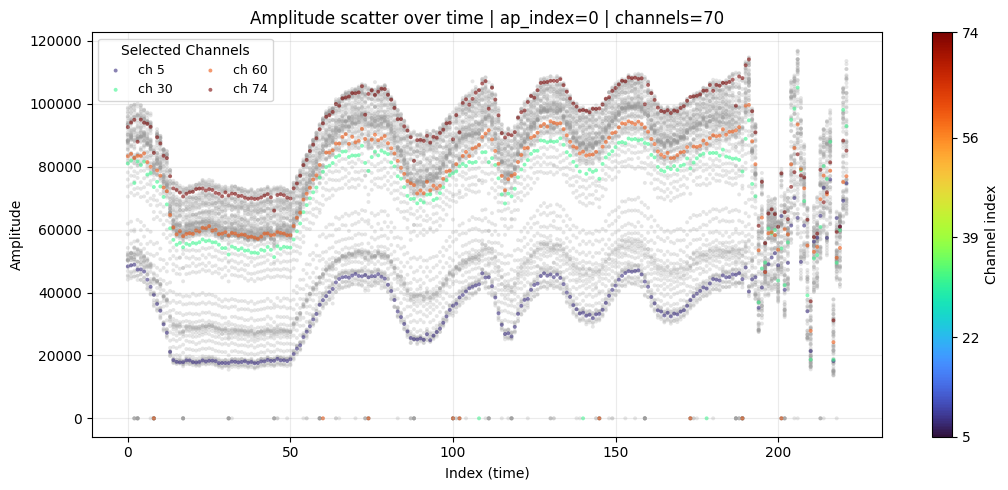

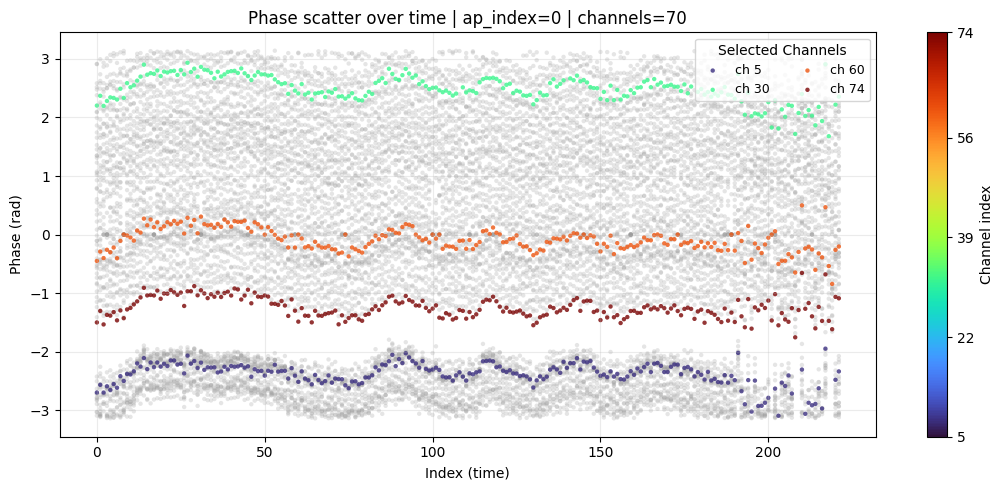

In [177]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from typing import List, Dict, Any, Optional, Iterable, Tuple

# 使用示例

# 幅值散点，先做鲁棒去极值（MAD，4σ），并限制相邻样本最大跳变为 3000：
# plot_channels_scatter_over_time(entries, ap_index=0, mode="magnitude", channels_to_use=range(75), apply_filter=True, filter_method="mad", filter_k=4.0, filter_max_step=3000, s=8, alpha=0.6)
# 相位散点，unwrap，用 IQR 过滤，k=3，并只高亮信道 [5, 22, 60]，其他通道灰色淡化：
# plot_channels_scatter_over_time(entries, ap_index=0, mode="phase", channels_to_use=range(75), unwrap_phase=True, apply_filter=True, filter_method="iqr", filter_k=3.0, highlight_channels=[5,22,60], grey_out_others=True, s=10)
# 参数建议

# filter_k：MAD 模式下 35 较常用；IQR 下 1.53.0 常见。
# filter_max_step：根据你的“正常变化范围”设定。如果幅值正常在 2万上下轻微波动，而异常能跳到 5万，可试 2500~4000。
# mode="clip" 会把极端值拉回阈值边界，曲线连续但不显示离群值；默认 "mask" 会直接置 NaN，让这些点不参与绘制。


# ---------- 数据准备（同前） ----------
import numpy as np
from typing import List, Dict, Any, Optional, Iterable, Tuple

DISABLED_REAL_CHS = {0, 1, 23, 24, 25, 77, 78, 79}

def prepare_series_from_entries(
    entries: List[Dict[str, Any]],
    ap_index: int,
    channels_to_use: Optional[Iterable[int]] = None,
    ensure_sorted_by_index: bool = True,
    channel_offset: int = 2,                 # 真实信道 = 源序号 + 2
    drop_disabled: bool = True,              # 是否丢弃禁用信道
) -> Tuple[np.ndarray, List[int], np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    将 entries 转为矩阵，并把源通道号（0..79）映射为真实信道号（+channel_offset）。
    - entries: list[dict]，每条含 e["channels"][src_ch] -> {I,Q,mag,phase_rad}
    - 返回的 chs 为“真实信道号”的有序列表（去除了禁用信道）。
    - channels_to_use 如果给的是“真实信道号”，也会正确筛选。
    """
    # 过滤 ap_index
    rows = [e for e in entries if int(e.get("ap_index", -1)) == ap_index]
    if ensure_sorted_by_index:
        rows.sort(key=lambda e: int(e["index"]))
    x = np.array([int(e["index"]) for e in rows], dtype=int)

    # 1) 收集所有“源序号”->“真实信道号”的映射
    # 源序号可能以字符串存储，统一转 int
    src_to_real = {}
    all_real = set()
    for e in rows:
        for ch_str in e["channels"].keys():
            src = int(ch_str)
            real = src + channel_offset
            src_to_real[src] = real
            all_real.add(real)

    # 2) 选择实际使用的真实信道号集合
    if channels_to_use is None:
        real_chs = sorted(all_real)
    else:
        # 外部传入的 channels_to_use 视为“真实信道号”
        real_chs = sorted(int(c) for c in channels_to_use)

    # 3) 丢弃禁用信道
    if drop_disabled:
        real_chs = [c for c in real_chs if c not in DISABLED_REAL_CHS]

    # 4) 反向映射：真实->源序号（一个真实号只会对应一个源序号）
    real_to_src = {real: src for src, real in src_to_real.items() if real in real_chs}

    # 5) 初始化矩阵
    C = len(real_chs)
    N = len(rows)
    I = np.full((N, C), np.nan, dtype=float)
    Q = np.full((N, C), np.nan, dtype=float)
    MAG = np.full((N, C), np.nan, dtype=float)
    PH = np.full((N, C), np.nan, dtype=float)

    real_index_map = {real: i for i, real in enumerate(real_chs)}

    # 6) 填充矩阵（用源序号访问数据，填到真实号对应的列）
    for n, e in enumerate(rows):
        chan_dict = e["channels"]
        for ch_str, v in chan_dict.items():
            src = int(ch_str)
            real = src + channel_offset
            if real not in real_index_map:
                continue
            ci = real_index_map[real]
            Ii = float(v.get("I", np.nan))
            Qi = float(v.get("Q", np.nan))
            I[n, ci] = Ii
            Q[n, ci] = Qi
            MAG[n, ci] = float(v.get("mag", np.hypot(Ii, Qi)))
            PH[n, ci] = float(v.get("phase_rad", np.arctan2(Qi, Ii)))

    # 返回的 chs 是“真实信道号”
    return x, real_chs, I, Q, MAG, PH


# ---------- 异常值过滤 ----------
def robust_filter_per_channel(
    Y: np.ndarray,
    method: str = "mad",  # "mad" 或 "iqr"
    k: float = 4.0,  # 阈值倍数（越大越宽松）
    max_step: Optional[
        float
    ] = None,  # 相邻样本允许的最大跳变（绝对值），超过则视为异常
    mode: str = "mask",  # "mask"=置为NaN；"clip"=裁剪到阈值边界
) -> Tuple[np.ndarray, np.ndarray]:
    """
    对每列（每个信道）进行鲁棒去极值。
    返回 (Y_filtered, mask_kept)；mask_kept=True 表示保留的点。
    """
    Y = np.asarray(Y, dtype=float)
    N, C = Y.shape
    Yf = Y.copy()
    keep = np.isfinite(Yf)

    for c in range(C):
        col = Yf[:, c]
        finite = np.isfinite(col)
        if not np.any(finite):
            continue
        xc = col[finite]
        if method == "mad":
            med = np.median(xc)
            mad = np.median(np.abs(xc - med))
            # 1.4826 为将 MAD 近似转化为标准差的因子
            sigma = 1.4826 * mad if mad > 0 else np.std(xc)
            lo, hi = med - k * sigma, med + k * sigma
        else:  # iqr
            q1, q3 = np.percentile(xc, [25, 75])
            iqr = q3 - q1
            lo, hi = q1 - k * iqr, q3 + k * iqr

        # 基于范围的过滤
        too_low = col < lo
        too_high = col > hi
        bad = (too_low | too_high) & finite

        # 基于最大跳变的过滤（可选）
        if max_step is not None and N >= 2:
            diff = np.abs(np.diff(col))
            jump_bad = np.zeros_like(col, dtype=bool)
            jump_bad[1:] |= diff > max_step
            jump_bad[:-1] |= diff > max_step
            bad |= jump_bad & finite

        if mode == "mask":
            col[bad] = np.nan
        else:  # "clip"
            col = np.clip(col, lo, hi)
            # 再把跳变异常置 NaN（若启用）
            if max_step is not None and N >= 2:
                col[jump_bad] = np.nan

        Yf[:, c] = col
        keep[:, c] &= np.isfinite(col)

    return Yf, keep


# ---------- 散点图，支持高亮与颜色条修复 ----------
def plot_channels_scatter_over_time(
    entries: List[Dict[str, Any]],
    ap_index: int = 0,
    mode: str = "amplitude",  # "magnitude" 或 "phase"
    channels_to_use: Optional[Iterable[int]] = None,
    max_channels: Optional[int] = None,
    unwrap_phase: bool = True,
    normalize_magnitude: bool = False,
    # 异常值过滤参数（可为 None 关闭）
    apply_filter: bool = True,
    filter_method: str = "mad",
    filter_k: float = 4.0,
    filter_max_step: Optional[float] = None,
    filter_mode: str = "mask",
    # 高亮相关
    highlight_channels: Optional[Iterable[int]] = None,
    grey_out_others: bool = True,
    base_grey: Tuple[float, float, float] = (0.6, 0.6, 0.6),
    base_alpha: float = 0.25,
    # 点样式
    cmap_name: str = "turbo",
    alpha: float = 0.8,
    s: float = 10.0,
    edgecolors: str = "none",
    title: Optional[str] = None,
    show_colorbar: bool = True,
):
    x, chs, I, Q, MAG, PH = prepare_series_from_entries(
        entries, ap_index, channels_to_use
    )

    if max_channels is not None and len(chs) > max_channels:
        chs = chs[:max_channels]
        x, chs, I, Q, MAG, PH = prepare_series_from_entries(entries, ap_index, chs)

    N, C = MAG.shape
    if C == 0 or N == 0:
        raise ValueError("没有可绘制的数据：检查 ap_index / channels_to_use 是否正确。")

    # 选择量
    if mode == "phase":
        Y = PH.copy()
        if unwrap_phase:
            for c in range(C):
                col = Y[:, c]
                if np.all(np.isnan(col)):
                    continue
                Y[:, c] = np.unwrap(col)
        else:
            Y = ((Y + np.pi) % (2 * np.pi)) - np.pi
        y_label = "Phase (rad, unwrapped)" if unwrap_phase else "Phase (rad)"
    else:
        Y = MAG.copy()
        if normalize_magnitude:
            for c in range(C):
                col = Y[:, c]
                m = np.nanmax(np.abs(col))
                if np.isfinite(m) and m > 0:
                    Y[:, c] = col / m
        y_label = "Amplitude (a.u.)" if normalize_magnitude else "Amplitude"

    # 异常值过滤
    if apply_filter:
        Y, keep_mask = robust_filter_per_channel(
            Y,
            method=filter_method,
            k=filter_k,
            max_step=filter_max_step,
            mode=filter_mode,
        )
    else:
        keep_mask = np.isfinite(Y)

    # 颜色映射与 colorbar（使用 Normalize，避免错位）
    ch_min, ch_max = min(chs), max(chs)
    cmap = plt.get_cmap(cmap_name)
    norm = mpl.colors.Normalize(vmin=ch_min, vmax=ch_max)

    fig, ax = plt.subplots(figsize=(11, 5))

    # 高亮集合
    hi_set = set(int(c) for c in (highlight_channels or []))

    # 先画“非高亮”的基底（灰色）
    if grey_out_others:
        for ci, ch in enumerate(chs):
            if ch in hi_set:
                continue
            yi = Y[:, ci]
            mask = np.isfinite(yi) & keep_mask[:, ci]
            if not np.any(mask):
                continue
            ax.scatter(
                x[mask],
                yi[mask],
                s=s,
                alpha=base_alpha,
                color=base_grey,
                edgecolors=edgecolors,
                label=None,
            )

    # 再画“高亮”或全部使用色图的曲线
    for ci, ch in enumerate(chs):
        # 若设置了高亮，仅对高亮通道使用色图；否则所有通道都用色图
        if highlight_channels is not None and ch not in hi_set:
            continue
        yi = Y[:, ci]
        mask = np.isfinite(yi) & keep_mask[:, ci]
        if not np.any(mask):
            continue
        ax.scatter(
            x[mask],
            yi[mask],
            s=s,
            alpha=alpha,
            color=cmap(norm(ch)),
            edgecolors=edgecolors,
            label=f"ch {ch}",
        )

    ax.set_xlabel("Index (time)")
    ax.set_ylabel(y_label)
    if title is None:
        title = f"{mode.capitalize()} scatter over time | ap_index={ap_index} | channels={len(chs)}"
    ax.set_title(title)
    ax.grid(True, alpha=0.25)

    # 颜色条：若只高亮少数通道，你可以选择仍显示全范围，或只显示高亮范围
    if show_colorbar:
        if highlight_channels:
            hi_list = sorted(hi_set)
            vmin = min(hi_list) if hi_list else ch_min
            vmax = max(hi_list) if hi_list else ch_max
            norm_cb = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        else:
            norm_cb = norm
        sm = mpl.cm.ScalarMappable(norm=norm_cb, cmap=cmap)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label("Channel index")
        ticks = np.linspace(norm_cb.vmin, norm_cb.vmax, num=5, dtype=int)
        cbar.set_ticks(ticks)
        cbar.set_ticklabels([str(t) for t in ticks])

    # 图例：只在高亮较少时显示
    if highlight_channels and len(hi_set) <= 10:
        ax.legend(title="Selected Channels", fontsize=9, ncol=2)

    # plt.xlim(60,160)
    plt.savefig(f'./finebre.fig/'+mode+'_highlight.svg', dpi=300)
    plt.savefig(f'./finebre.fig/'+mode+'_highlight.png', dpi=300)
    plt.savefig(f'./finebre.fig/'+mode+'_highlight.pdf', dpi=300)  
    plt.tight_layout()
    plt.show()


# plot_channels_scatter_over_time(
#     data_to_parse,
#     ap_index=0,
#     mode="magnitude",
#     channels_to_use=range(75),
#     s=8,
#     alpha=0.6,
# )
# plot_channels_scatter_over_time(
#     data_to_parse,
#     ap_index=0,
#     mode="phase",
#     channels_to_use=range(75),
#     unwrap_phase=False,
#     s=12,
# )
# plot_channels_scatter_over_time(
#     data_to_parse,
#     ap_index=0,
#     mode="magnitude",
#     channels_to_use=range(75),
#     apply_filter=False,
#     # filter_method="mad",
#     # filter_k=4.0,
#     # filter_max_step=10000,
#     s=8,
#     alpha=0.6,
# )
highlight_channels_to_use = [5,30,60,74]
plot_channels_scatter_over_time(
    data_to_parse,
    ap_index=0,
    mode="amplitude",
    channels_to_use=range(75),
    apply_filter=False,
    # filter_method="mad",
    # filter_k=4.0,
    # filter_max_step=10000,
    s=8,
    alpha=0.6,
    highlight_channels=highlight_channels_to_use,
    grey_out_others=True,
)
plot_channels_scatter_over_time(
    entries,
    ap_index=0,
    mode="phase",
    channels_to_use=range(75),
    unwrap_phase=False,
    apply_filter=True,
    filter_method="iqr",
    filter_k=3.0,
    highlight_channels=highlight_channels_to_use,
    grey_out_others=True,
    s=10,
)